# Diginal Image Processing (EEE5320.01) Project
Author: SukJoon Oh, acoustikue@yonsei.ac.kr  
Date: 11/21/2021

- Environment: Jupyter Notebook, Python 3.9  
- Module: numpy, math, matplotlib  
  
This project is first written in C using libtiff, a default Linux-contained library. It can be used in loading the `TIFF` format image. However, it requires complex memory control which degrades productivity. Thus, I switched to used Python that offers easy way to control image as `numpy.array` type. numpy module provides more optimized result as the library is written in C.  
  
This is the part of the code that I've tried.
  
```c
// ...
TIFF* tif;      
tif = TIFFOpen(filename_1, "r");

if (tif) {
    printf("\nFile \"%s\" successfully opened. \nPreparing...\n", filename_1);

    TIFFGetField(tif, TIFFTAG_IMAGEWIDTH,       &wid);
    TIFFGetField(tif, TIFFTAG_IMAGELENGTH,      &len);
    TIFFGetField(tif, TIFFTAG_SAMPLESPERPIXEL,  &chl);

    wid_byte = TIFFScanlineSize(tif);
    assert(wid_byte == sizeof(uint8_t) * chl * wid); // Test
                
// ...
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
# import PIL

filename_1 = 'image1.tif'
filename_2 = 'image2.tif'

The first book cover image is set to image1.tif, and the second Florida beach image is set to image2.tif.

## 1. Book Cover

The first image has three channel; R, G, and B. Each RGB value does not show large variance. Since it is easy to process an image with single black and white channel, it is first pre-processed with averaging. It shows that the modified image is almost the same with the original image.


Shape: (412, 409, 3), Type: uint32


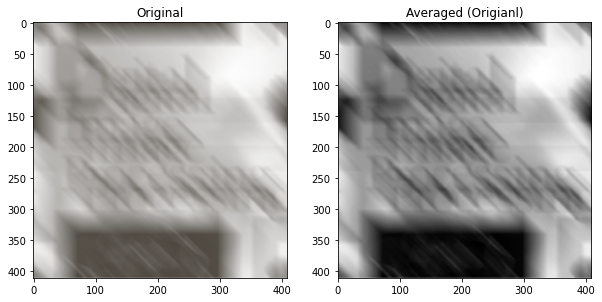

In [2]:
img = plt.imread(filename_1) # Read the image
img = img.astype('uint32') 

# The image is first loaded as uint8. 
# Averaging may induce overflow and this causes cutout in values.
# Thus, we need to convert into uint32 type to offer generous free space in averaging process.

print(f'Shape: {img.shape}, Type: {img.dtype}') # Shows Type.

R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]

av_img = np.array((R + G + B) / 3, dtype='uint32') # Averaging

#
# Plot the image
fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Original')
ax1.imshow(img)

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Averaged (Origianl)')
ax2.imshow(av_img, cmap='gray')

img = av_img # Replace the origial image

### Averaging
The process below shows how the Fourier transformed frequency component is shown. 

(412, 409)


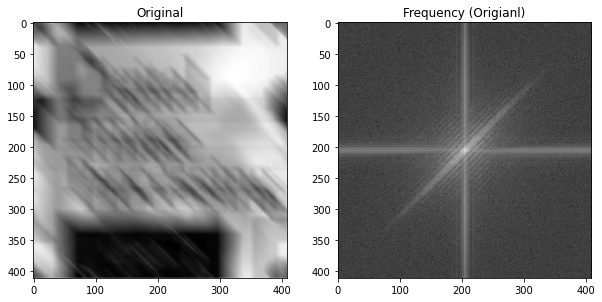

In [3]:
# I used fft module in composing frequency domain, which is commonly used.
# This is the only built-in function used throughout the project.

G = np.fft.fft2(img)
G_shift = np.fft.fftshift(G) # Shift the converted image
print(G_shift.shape) # The shape?

#
# Plot the image
fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Original')
ax1.imshow(np.abs(img), cmap='gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Frequency (Origianl)')
ax2.imshow(np.log(1 + np.abs(G_shift)), cmap='gray')

plt.show()

### Basic Functions
The below shows five functions that are used in this project.  

- `gen_degfunc` : Generates motion blur degradation function. It returns a full 2D array, not each component. `a`, `b`, and `T` should be given as parameters.
- `do_weiner` : Computes Wiener filter. The parameter `H`, `G` and `K` should be provided.
- `get_histogram` : Shows the histogram of an image.
- `ideal_notch` : Applies ideal notch filter at given points. The `point` should be given as the `list` of 2-element `list`. `d0` is the radius distance.
- `gau_notch` : Applies Gaussian notch filter at given points. The arguments are the same with `ideal_notch`

In [4]:
#
# Generates motion blur degradation function.
def gen_degfunc(img_shape, a, b, T):
    
    M = img_shape[0]
    N = img_shape[1]
    H = np.ones((M, N), dtype='complex128')
    
    for u in range(M):
        for v in range(N):
            C = math.pi * (a * (u - M / 2) + b * (v - N / 2))

            if (C == 0): H[u, v] = T;
            else: H[u, v] = (T / C) * math.sin(C) * math.e ** (-1j * C)
                
    return H


#
# Computes Wiener filter
def do_weiner(H, G, K):
    Wt = (np.abs(H) ** 2) # Top part
    Wb = (Wt + K) # Bottom part
    W = Wt / Wb # Wiener coef
    H = H / W # H
    
    #
    # Normalizing
    H_norm = H / np.abs(H.max())
            
    G_norm = G / np.abs(G.max())
    F_temp = G_norm / H_norm
    F_norm = F_temp / np.abs(F_temp.max())

    F_hat  = F_norm * abs(G.max())
    
    # Return the estimated F_hat
    return F_hat

#
# Plots the given image's histogram
def get_histogram(img, title):
    fig = plt.figure()
    hist_data = img.flatten() # Flatten the image to 1-D array.
    
    plt.hist(hist_data, range=(0, 255), lw=0, color='black', bins=256)
    plt.title(title)
    plt.plot()
    plt.show()
    
#
# Applies ideal notch filter at given points.
def ideal_notch(fshift, points, d0):
    
    for u in range(fshift.shape[0]):
        for v in range(fshift.shape[1]):
            for d in range(len(points)):
                
                u0 = points[d][0]
                v0 = points[d][1]
                u0, v0 = v0, u0
                
                d1 = math.pow(math.pow(u - u0, 2) + math.pow(v - v0, 2), 1)
                d2 = math.pow(math.pow(u + u0, 2) + math.pow(v + v0, 2), 1)
                
                if d1 <= d0 or d2 <= d0:
                    fshift[u][v] *= 0.0 # Make it zeros.
    return fshift

#
# Applies Gaussian notch filter at given points.
def gau_notch(fshift, points, d0):
    
    for u in range(fshift.shape[0]):
        for v in range(fshift.shape[1]):
            for d in range(len(points)):
                
                u0 = points[d][0]
                v0 = points[d][1]
                u0, v0 = v0, u0     
                
                d1 = math.pow(math.pow(u - u0, 2) + math.pow(v - v0, 2), 0.5)
                d2 = math.pow(math.pow(u + u0, 2) + math.pow(v + v0, 2), 0.5)
                
                fshift[u][v] *= (1 - math.exp(-0.5 * (d1 * d2 / math.pow(d0, 2))))
                # Do apply the Gaussian equation.
                
    return fshift
    

### Applying Filters
Code snippet below shows the three images, which are the inverse filtered image (with motion blur degradation function), Wiener filtered image, and their corresponding frequency domain. 

The parameter used was: `a`, `b`, `T`, and `K`.

Shape: (412, 409), Type: uint8


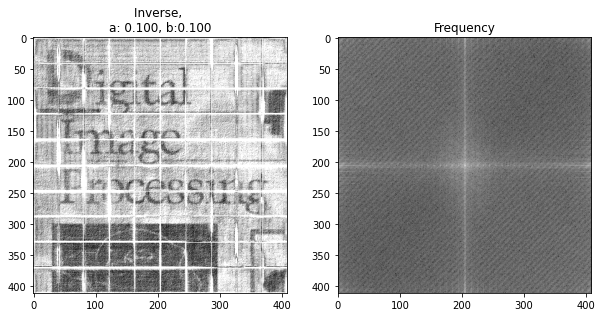

Shape: (412, 409), Type: uint8


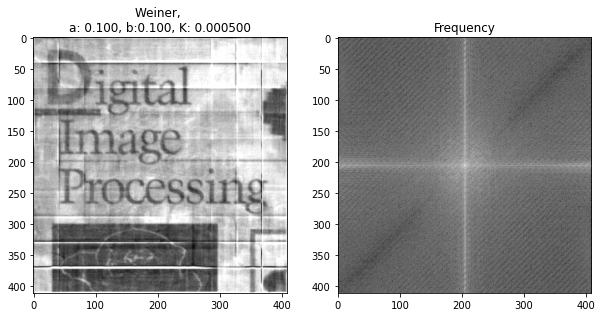

Shape: (412, 409), Type: uint32


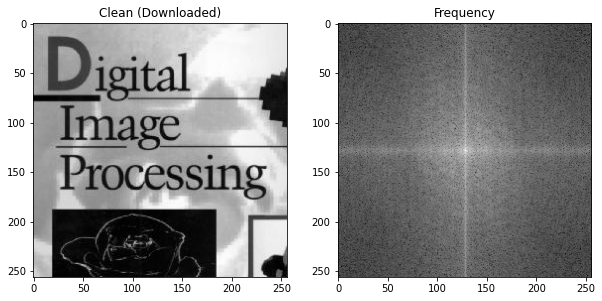

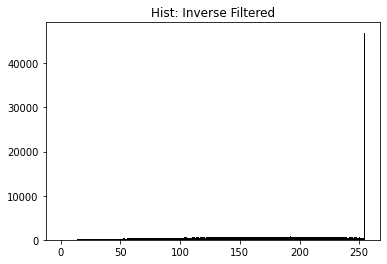

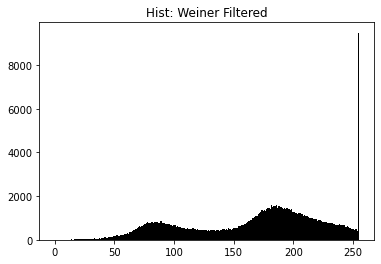

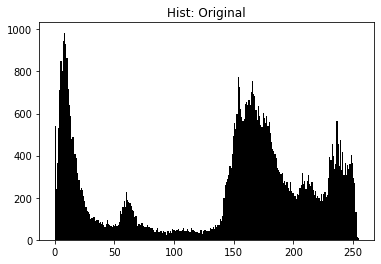

In [5]:
T = 1
a = 0.1
b = 0.1
K = 0.0005

H = gen_degfunc(img.shape, a, b, T) # Get Degradation Function

#
#
# Inverse

F_hat = G_shift / H

rst_inv = np.fft.ifft2(F_hat)
rst_inv = np.abs(rst_inv)

#
# Turn into uint8
for i in range(rst_inv.shape[0]):
    for j in range(rst_inv.shape[1]):
        if (rst_inv[i, j] > 255): rst_inv[i, j] = 255
            
rst_inv = rst_inv.astype('uint8') # Conversion
print(f'Shape: {rst_inv.shape}, Type: {rst_inv.dtype}') # Type?

rst_inv_dft_shift = np.fft.fftshift(np.fft.fft2(rst_inv)) # Restore

#
# Plot the image
fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Inverse, \na: %.3f, b:%.3f' % (a, b))
ax1.imshow(rst_inv, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Frequency')
# ax2.imshow(np.log(1 + np.abs(F_hat)), cmap='gray')
ax2.imshow(np.log(1 + np.abs(rst_inv_dft_shift)), cmap='gray')

plt.show()


#
#
# Weiner
F_hat = do_weiner(H, G_shift, K) # Weiner

rst_wei = np.fft.ifft2(F_hat)
rst_wei = np.abs(rst_wei) # Restore

#
# Turn into uint8
for i in range(rst_wei.shape[0]):
    for j in range(rst_wei.shape[1]):
        if (rst_wei[i, j] > 255): rst_wei[i, j] = 255
            
rst_wei = rst_wei.astype('uint8') # Conversion
print(f'Shape: {rst_wei.shape}, Type: {rst_wei.dtype}') # Type?

rst_wei_dft_shift = np.fft.fftshift(np.fft.fft2(rst_wei)) # Restore

#
# Plot the image
fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Weiner, \na: %.3f, b:%.3f, K: %f' % (a, b, K))
ax1.imshow(rst_wei, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Frequency')
# ax2.imshow(np.log(1 + np.abs(F_hat)), cmap='gray')
ax2.imshow(np.log(1 + np.abs(rst_wei_dft_shift)), cmap='gray')

plt.show()
# plt.savefig(f'res/res-wei-{i}.png')


#
#
# Extra
exi = plt.imread('book.jpg')
exi = exi.astype('uint32')

exd = np.fft.fft2(exi)
exd_shift = np.fft.fftshift(exd)
print(f'Shape: {img.shape}, Type: {exi.dtype}')

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Clean (Downloaded)')
ax1.imshow(exi, cmap='gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Frequency')
ax2.imshow(np.log(1 + np.abs(exd_shift)), cmap='gray')
# ax2.imshow(np.log(1 + np.abs(exd_shift)))

plt.show()


#
# Histograms
get_histogram(rst_inv, 'Hist: Inverse Filtered')
get_histogram(rst_wei, 'Hist: Weiner Filtered')
get_histogram(exi, 'Hist: Original')

### Histogram Equalization
The function below shows how histogram equalization process is implemented. `cumulative_sum` literally computes the cumulative sum, and the `hist_eq` uses the function to make equalized histogram.

In [6]:
#
# Cumulative Sum
def cumulative_sum(hist):
    it = iter(list(hist))
    new = [next(it)]
    for i in it: new.append(new[-1] + i)
        
    return np.array(new)

#
# Histogram Equalization
def hist_eq(img):
    flat = img.flatten()
    hist, bin_edges = np.histogram(flat, bins=256)
    
    cum_sum = cumulative_sum(hist)

    x = (cum_sum - cum_sum.min()) * 255
    N = cum_sum.max() - cum_sum.min()
    cum_sum = x / N

    cum_sum = cum_sum.astype('uint8') # Convert it to where it was.

    img_new = cum_sum[flat]
    img_new = np.reshape(img_new, img.shape)
    
    return img_new


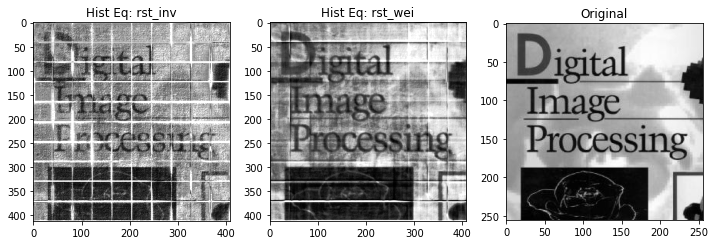

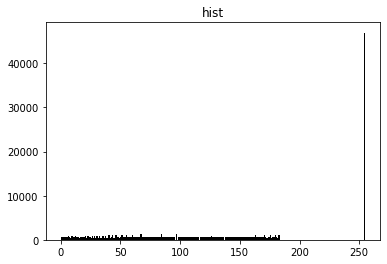

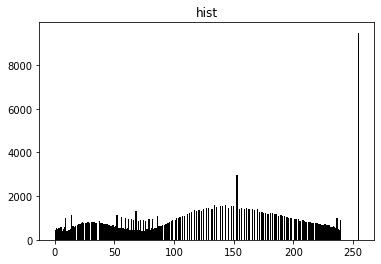

In [7]:
# Eq
rst_inv_histeq = hist_eq(rst_inv)
rst_wei_histeq = hist_eq(rst_wei)

#
# Show images
fig = plt.figure(figsize=(12, 24))
ax1 = fig.add_subplot(1, 3, 1)
ax1.title.set_text('Hist Eq: rst_inv')
ax1.imshow(rst_inv_histeq, cmap='gray')

ax2 = fig.add_subplot(1, 3, 2)
ax2.title.set_text('Hist Eq: rst_wei')
ax2.imshow(rst_wei_histeq, cmap='gray')

ax3 = fig.add_subplot(1, 3, 3)
ax3.title.set_text('Original')
ax3.imshow(exi, cmap='gray')

get_histogram(rst_inv_histeq, 'hist')
get_histogram(rst_wei_histeq, 'hist')

### Power Law Transformation

In [8]:
#
# Power Law Transformation
def power_law(img, c, r):
    img = c * img ** r
    img.astype('uint8')
    return img

The function `power_law` describes power law transformation. In this paper, the `c` is set to 1, and the `r` is set to 0.8.

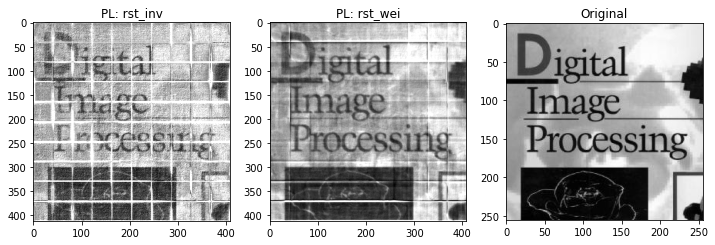

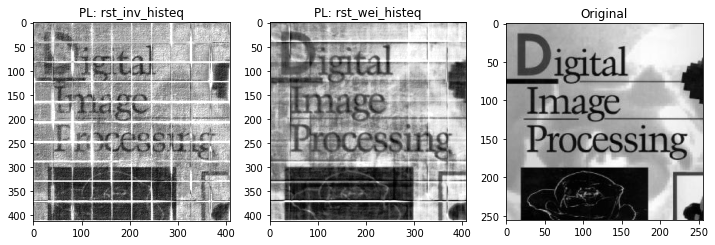

In [9]:
# Power Law
rst_inv_pl = power_law(rst_inv, 1, 1.4)
rst_wei_pl = power_law(rst_wei, 1, 1.4)

#
# Show images
fig = plt.figure(figsize=(12, 24))
ax1 = fig.add_subplot(1, 3, 1)
ax1.title.set_text('PL: rst_inv')
ax1.imshow(rst_inv_pl, cmap='gray')

ax2 = fig.add_subplot(1, 3, 2)
ax2.title.set_text('PL: rst_wei')
ax2.imshow(rst_wei_pl, cmap='gray')

ax3 = fig.add_subplot(1, 3, 3)
ax3.title.set_text('Original')
ax3.imshow(exi, cmap='gray')


# Power Law
rst_inv_hepl = power_law(rst_inv_histeq, 1, 0.8)
rst_wei_hepl = power_law(rst_wei_histeq, 1, 0.8)

#
# Show images
fig = plt.figure(figsize=(12, 24))
ax1 = fig.add_subplot(1, 3, 1)
ax1.title.set_text('PL: rst_inv_histeq')
ax1.imshow(rst_inv_hepl, cmap='gray')

ax2 = fig.add_subplot(1, 3, 2)
ax2.title.set_text('PL: rst_wei_histeq')
ax2.imshow(rst_wei_hepl, cmap='gray')

ax3 = fig.add_subplot(1, 3, 3)
ax3.title.set_text('Original')
ax3.imshow(exi, cmap='gray')

### Notch Filters
Code below shows how the points were estimated to apply notch filters. The points were manually observed and generated through iterations. Since grid pattern in spatial domain have its regular impulse components in the frequency domain, it is relatively easy to predict the positions.

Type: complex128
Type: uint8 (After)


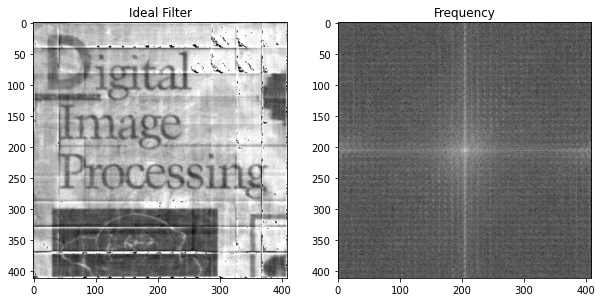

In [10]:
#
# Ideal Notch Filter
# Gaussian Notch Filter

# Generate points
# start = [4, 6]
points_1 = [[4, 6]]
middle_lim = 190

#
# Estimation: Points to apply notch filter.
for i in range(205):
    for i in range(204):
        if (points_1[-1][1] < middle_lim):
            points_1.append([points_1[-1][0], points_1[-1][1] + 10])
            
    if (points_1[-1][0] < middle_lim):
        points_1.append([points_1[-1][0] + 10, 6])

points_2 = [] # Second estimation
for elem in points_1:
    points_2.append([409 - elem[0], elem[1]])

points = points_1 + points_2

# Apply Gaussian Notch
rst_inv_not = gau_notch(rst_wei_dft_shift, points, 2)
rst_inv_not = np.fft.ifft2(rst_inv_not)

print(f"Type: {rst_inv_not.dtype}") # Type?
rst_inv_not = np.abs(rst_inv_not).astype('uint8') # Convert

for i in range(rst_inv_not.shape[0]):
    for j in range(rst_inv_not.shape[1]):
        if (rst_inv_not[i, j] > 255): rst_inv_not[i, j] = 255

print(f"Type: {rst_inv_not.dtype} (After)") # Type?

#
# Plot the images
fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Ideal Filter')
ax1.imshow(rst_inv_not, cmap='gray')

rst_inv_not_dft_shift = np.fft.fftshift(np.fft.fft2(rst_inv_not))

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Frequency')
ax2.imshow(np.log(1 + np.abs(rst_inv_not_dft_shift)), cmap='gray')

plt.show()

The figure shows the image restoration is not good. There are two possibilities:

- The overflow control might be the case with the blacked area.
- The filter implementation might not be correcly done.
- The notch point estimation was incorrect.

### Extra: Gaussian Kernel

The process below shows an extra process, applying Gaussian low pass filter. Although it has been applied, it does not show any better result.

In [11]:
#
# Genertes Gaussian Kernel
def gen_gaussian_kernel(k_size, sigma):
    center = k_size // 2
    x, y = np.mgrid[0 - center : k_size - center, 0 - center : k_size - center]
    g_kernel = 1 / (2 * np.pi * sigma) * np.exp(-(np.square(x) + np.square(y)) / (2 * np.square(sigma)))
    return g_kernel

#
# Gaussian Filter Apply
def gaussian_filter(image, k_size, sigma):
    height, width = image.shape[0], image.shape[1]

    dst_h = height - k_size + 1
    dst_w = width - k_size + 1
    img_arr = np.zeros((dst_h * dst_w, k_size * k_size))
    
    import itertools

    row = 0
    for i, j in itertools.product(range(dst_h), range(dst_w)):
        wnd = np.ravel(image[i:i + k_size, j:j + k_size])
        img_arr[row, :] = wnd
        row += 1

    g_kernel = gen_gaussian_kernel(k_size, sigma) # Get the kernel

    # Reshape, type conversion
    dst = np.dot(img_arr, np.ravel(g_kernel)).reshape(dst_h, dst_w).astype('uint8')

    return dst

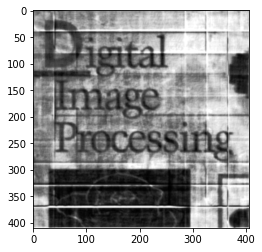

In [12]:
#
# Extra: Gaussian Low Pass
new_img = gaussian_filter(rst_wei_histeq, 3, sigma=0.8)
new_img = new_img.astype('uint8')

plt.imshow(new_img, cmap='gray')
plt.show()

## 2. Florida Beach

Unlike the first image, the second image has single channel: black and white. 


In [13]:
img = plt.imread(filename_2)
img = img.astype('uint8')

print(f'Shape: {img.shape}, Type: {img.dtype}') # Type?

Shape: (588, 600), Type: uint8


(588, 600)


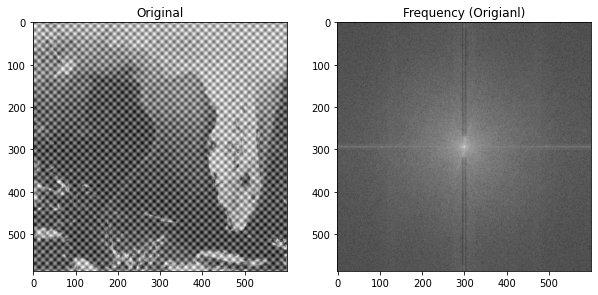

In [14]:
# I used fft module in composing frequency domain, which is commonly used.
# This is the only built-in function used throughout the project.

G = np.fft.fft2(img)
G_shift = np.fft.fftshift(G)
print(G_shift.shape) # Type?

#
# Plot the image
fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Original')
ax1.imshow(np.abs(img), cmap='gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Frequency (Origianl)')
ax2.imshow(np.log(1 + np.abs(G_shift)), cmap='gray')

plt.show()

There is patterned noise. In the frequency domain, it clearly shows the impulse components in lower frequency range. In this case, simple ideal notch filter appliying will do to eliminate the components.

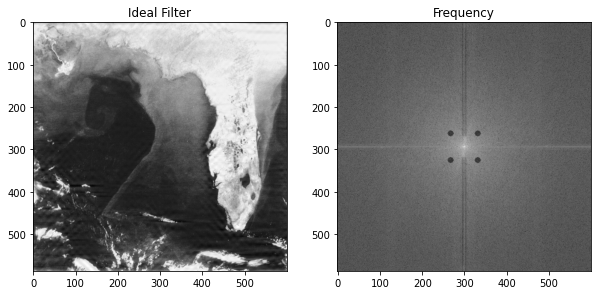

In [15]:
G_shift = ideal_notch(G_shift, [[268, 263], [332, 263], [268, 326], [332, 326]], 50)

rst_inf = np.fft.ifft2(G_shift)
rst_inf = np.abs(rst_inf).astype('uint8')

#
# Show the image
fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Ideal Filter')
ax1.imshow(rst_inf, cmap='gray')

rst_inf_dft_shift = np.fft.fftshift(np.fft.fft2(rst_inf)) # Get the FFT

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Frequency')
ax2.imshow(np.log(1 + np.abs(rst_inf_dft_shift)), cmap='gray')

plt.show()